# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [2]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Učitavanje podataka

In [41]:
# Za prikazivanje cijelih komentara
# pd.set_option("max_colwidth", 0)

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [5]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [6]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

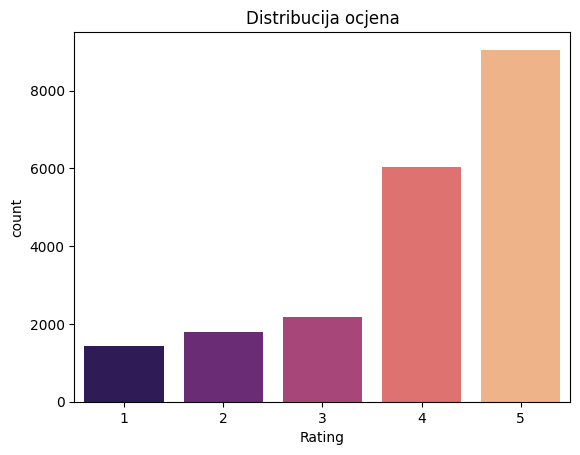

In [7]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [8]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [9]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [10]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

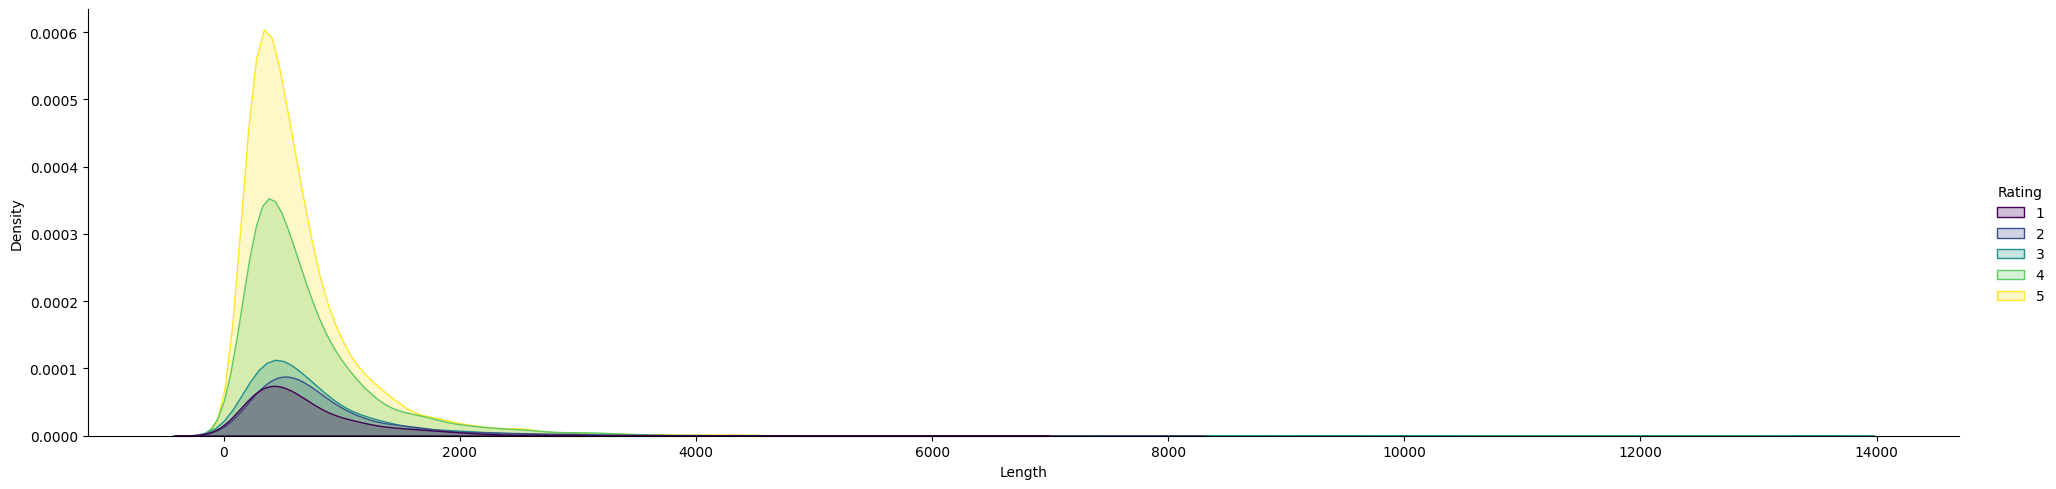

In [11]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [12]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

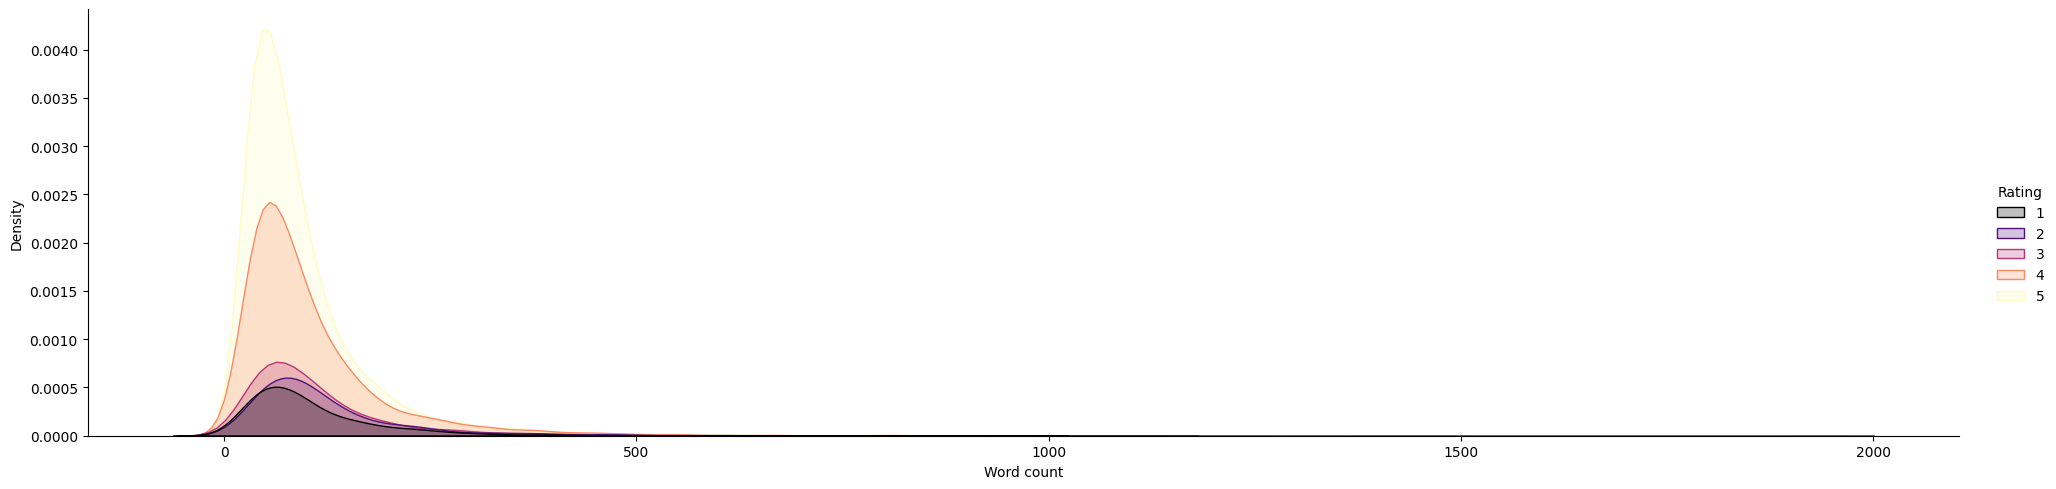

In [13]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [14]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [15]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [16]:
df['Review'] = df['Review'].apply(clean)

In [17]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [18]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [19]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [20]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [21]:
words, freq = zip(*most_common_words)

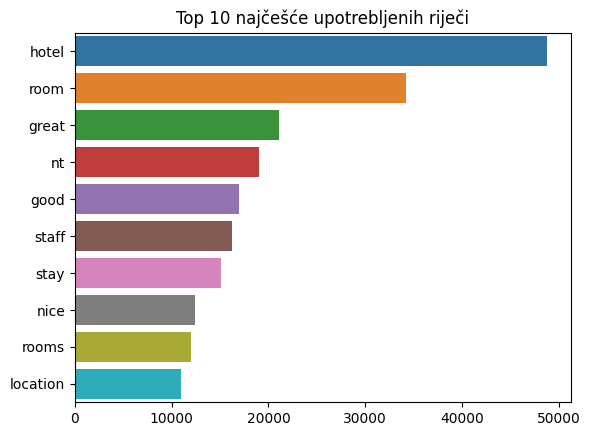

In [22]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [23]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

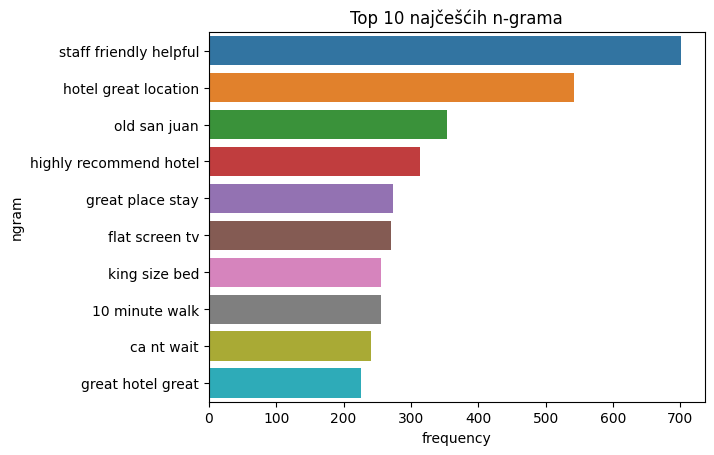

In [24]:
n_gram = display_ngram(3, df)

## Analiza sentimenta

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer

In [58]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')

# Pretprocesiranje teksta
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).lower())

In [59]:
df['Label'] = df['Rating'].apply(lambda x: 'Negative' if x in [1, 2] else ('Neutral' if x == 3 else 'Positive'))

In [60]:
# Tokenizacija
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

In [61]:
# Padding
max_len = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_len)

In [62]:
# One-hot kodiranje oznaka
labels = pd.get_dummies(df['Label']).values
labels

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

// TODO
- reduce vocab size
- reduce epochs
- try out single layer RNN
- try out GRU
- implement GRU with GloVe/Word2Vec

In [9]:
model1 = Sequential()
model1.add(Embedding(5000, 128, input_length=max_len))  # 4000 je veličina vokabulara, 128 je dimenzija embeddinga
model1.add(SimpleRNN(16))  # jedinice u RNN sloju
model1.add(Dropout(0.5))   # Dropout za smanjenje preprilagođenosti
model1.add(Dense(3, activation='softmax'))  # Izlazni sloj s tri klase

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
97/97 [==============================] - 189s 2s/step - loss: 0.8086 - accuracy: 0.6864 - val_loss: 0.6033 - val_accuracy: 0.7931
Epoch 2/10
97/97 [==============================] - 189s 2s/step - loss: 0.5614 - accuracy: 0.8112 - val_loss: 0.5399 - val_accuracy: 0.8028
Epoch 3/10
97/97 [==============================] - 181s 2s/step - loss: 0.4601 - accuracy: 0.8482 - val_loss: 0.5129 - val_accuracy: 0.8158
Epoch 4/10
97/97 [==============================] - 183s 2s/step - loss: 0.3727 - accuracy: 0.8751 - val_loss: 0.5260 - val_accuracy: 0.8133
Epoch 5/10
97/97 [==============================] - 179s 2s/step - loss: 0.3002 - accuracy: 0.9023 - val_loss: 0.5473 - val_accuracy: 0.8114
Epoch 6/10
97/97 [==============================] - 180s 2s/step - loss: 0.2398 - accuracy: 0.9269 - val_loss: 0.5554 - val_accuracy: 0.8087


In [ ]:
model1.evaluate(X_test, y_test)

129/129 [==============================] - 18s 136ms/step - loss: 0.5031 - accuracy: 0.8246


[0.5030768513679504, 0.824591338634491]

In [ ]:
# Definiranje modela
model2 = Sequential()
model2.add(Embedding(5000, 128, input_length=max_len))  # 5000 je veličina vokabulara, 128 je dimenzija embeddinga
model2.add(GRU(64))  # 64 jedinice u GRU sloju
model2.add(Dropout(0.5))  # Dropout za smanjenje preprilagođenosti
model2.add(Dense(3, activation='softmax'))  # 3 izlazne jedinice za tri klase sentimenta

# Kompilacija modela
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Postavljanje rano zaustavljanja
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Treniranje modela
history = model2.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
97/97 [==============================] - 18s 160ms/step - loss: 0.7459 - accuracy: 0.7292 - val_loss: 0.5681 - val_accuracy: 0.7765
Epoch 2/10
97/97 [==============================] - 14s 142ms/step - loss: 0.4930 - accuracy: 0.8101 - val_loss: 0.4659 - val_accuracy: 0.8148
Epoch 3/10
97/97 [==============================] - 13s 133ms/step - loss: 0.3492 - accuracy: 0.8668 - val_loss: 0.4141 - val_accuracy: 0.8399
Epoch 4/10
97/97 [==============================] - 12s 123ms/step - loss: 0.3011 - accuracy: 0.8878 - val_loss: 0.4406 - val_accuracy: 0.8438
Epoch 5/10
97/97 [==============================] - 11s 111ms/step - loss: 0.2386 - accuracy: 0.9134 - val_loss: 0.5019 - val_accuracy: 0.8192
Epoch 6/10
97/97 [==============================] - 9s 94ms/step - loss: 0.2033 - accuracy: 0.9257 - val_loss: 0.5626 - val_accuracy: 0.8343


---

In [ ]:
model = Sequential()
model.add(Embedding(5000, 128, input_length=max_len))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Dropout(0.6))
model.add(SimpleRNN(32))
model.add(Dropout(0.6))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
97/97 [==============================] - 373s 4s/step - loss: 0.8992 - accuracy: 0.6461 - val_loss: 0.5486 - val_accuracy: 0.7938
Epoch 2/10
97/97 [==============================] - 363s 4s/step - loss: 0.5854 - accuracy: 0.7975 - val_loss: 0.4888 - val_accuracy: 0.8297
Epoch 3/10
97/97 [==============================] - 362s 4s/step - loss: 0.4483 - accuracy: 0.8472 - val_loss: 0.4779 - val_accuracy: 0.8348
Epoch 4/10
97/97 [==============================] - 377s 4s/step - loss: 0.3737 - accuracy: 0.8715 - val_loss: 0.5355 - val_accuracy: 0.8421
Epoch 5/10
97/97 [==============================] - 365s 4s/step - loss: 0.3090 - accuracy: 0.8912 - val_loss: 0.6136 - val_accuracy: 0.8370


In [ ]:
model.evaluate(X_test, y_test)

129/129 [==============================] - 19s 144ms/step - loss: 0.5175 - accuracy: 0.8217


[0.5174793601036072, 0.8216637969017029]